In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [6]:
data = pd.read_excel('/var/ANZ synthesised transaction dataset.xlsx')
data.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [7]:
salary_df = pd.DataFrame({"customer_id": data.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [8]:
df_freq = []
df_amount = []

for customer in range(len(salary_df)):
    salary = data.loc[(data.customer_id == salary_df.customer_id[customer]) & (data.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
    count = len(salary)
    if count == 0:
        df_amount.append(np.nan)
        df_freq.append(np.nan)
    else:
        days_between_payments = []
        for date in range(len(salary)-1):
            days_between_payments.append((salary.date[date + 1] - salary.date[date]).days)
        df_freq.append(max(days_between_payments))
        df_amount.append(mode(salary.amount))

salary_df["salary_freq"] = df_freq
salary_df["salary_amount"] = df_amount       
salary_df["annual_salary"] = salary_df["salary_amount"] / salary_df["salary_freq"] * 365.25
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Annual salary')

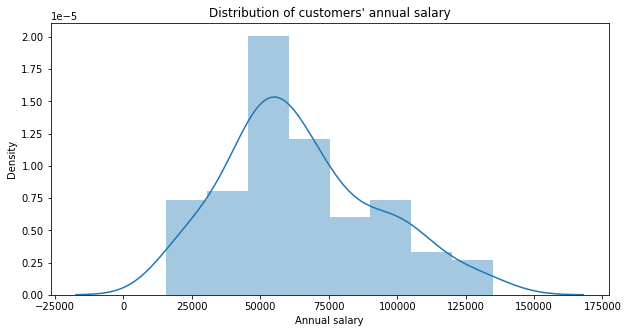

In [9]:
plt.figure(figsize = (10, 5))
sns.distplot(salary_df.annual_salary)
plt.title("Distribution of customers' annual salary")
plt.xlabel("Annual salary")

In [11]:
## creating variables for prediction
# Unique customer id's 
unique_id = data.customer_id.unique()
len(unique_id)

100

In [12]:

avg_no_weekly_trans = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "date"]
    avg_no_weekly_trans.append(round(len(array)/array.nunique()*7))
avg_no_weekly_trans[:5]

[48, 29, 24, 14, 21]

In [13]:
max_amount = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "amount"]
    max_amount.append(max(array))
max_amount[:5]

[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

In [14]:

no_large_trans = []
for id_ in unique_id:
    count = 0
    array = data.loc[data.customer_id == id_, "amount"]
    for amount in array:
        if amount > 100:
            count += 1
    no_large_trans.append(count)
no_large_trans[:5]

[22, 23, 22, 25, 32]

In [15]:

no_days_with_trans = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "date"]
    no_days_with_trans.append(array.nunique())
no_days_with_trans[:5]

[85, 74, 76, 63, 44]

In [16]:
avg_trans_amount = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "amount"]
    avg_trans_amount.append(array.mean())
avg_trans_amount[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

In [17]:
median_balance = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "balance"]
    median_balance.append(array.median())
median_balance[:5]

[1580.4, 1132.66, 3618.5, 5616.63, 6162.45]

In [18]:
# Assume customers live in the state where most of their transactions occured
state = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "merchant_state"]
    state.append(mode(array))
state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

In [19]:
age = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "age"]
    age.append(mode(array))
age[:5]

[26, 38, 40, 20, 43]

In [20]:

gender = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "gender"]
    gender.append(mode(array))
gender[:5]

['F', 'M', 'F', 'M', 'F']

In [21]:
# Predictor variables 
features_df = pd.DataFrame({"customer_id": unique_id, 
                            "avg_no_weekly_trans": avg_no_weekly_trans, 
                            "max_amount": max_amount, 
                            "no_large_trans": no_large_trans,
                            "avg_trans_amount": avg_trans_amount,
                            "median_balance": median_balance, 
                            "state": state,
                            "age": age,
                            "gender": gender})
features_df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F


In [22]:
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


In [23]:
df = pd.concat([features_df, salary_df.annual_salary], axis = 1)
df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender,annual_salary
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F,52891.852500
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M,52289.711786
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F,46547.981786
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M,60534.969643
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F,55728.801429


In [43]:
df = df.dropna()

In [44]:
## moving on to test train split

In [45]:
X = df.drop(["customer_id","annual_salary"], axis = 1)
Y = df.annual_salary


In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(39, 8)
(39,)
(18, 8)
(18,)


In [47]:
ohe = OneHotEncoder(sparse = False)
scaler = StandardScaler()
column_transform = make_column_transformer((ohe, ["state", "gender"]), (scaler, ["avg_no_weekly_trans", "max_amount", "no_large_trans", "avg_trans_amount", "median_balance", "age"]))

In [48]:
lm = LinearRegression()
lm_pipeline = make_pipeline(column_transform, lm)

In [49]:

# Fit pipeline and make predictions 
lm_pipeline.fit(X_train, Y_train)
lm_pred = lm_pipeline.predict(X_test)

In [50]:
# RMSE
print("RMSE: ", round(np.sqrt(mean_squared_error(lm_pred, Y_test))))

RMSE:  20261


In [51]:
tree = DecisionTreeRegressor()
tree_pipeline = make_pipeline(column_transform, tree)

In [52]:
tree_pipeline.fit(X_train, Y_train)
tree_pred = tree_pipeline.predict(X_test)

In [53]:
print("RMSE: ", round(np.sqrt(mean_squared_error(tree_pred, Y_test))))

RMSE:  21350
